# Evaluating basis functions of the Shim Loops

In [ ]:
import argparse
import signal
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time
from helpersFunctions import *
import ipywidgets as widgets
from IPython.display import display, clear_output

sys.path.append('..')

from shimTool.Tool import Tool, ShimMode
from shimTool.dicomUtils import *
from shimTool.shimCompute import *

In [ ]:
# the goal is to take a bunch of fieldmap for every coil independently with a bunch of different currents...
# and then check to see if the fieldmap is linearly correlated with the current for every coil

def applyCurrentGetFieldmap(tool: Tool, loopIdx: int, current: float):
    tool.shimInstance.shimZero()
    tool.shimInstance.shimSetCurrentManual(loopIdx, current)
    tool.doFieldmapScan()
    return computeFieldmapFromLatestFieldmapScan(tool)

def applyGradientGetFieldmap(tool: Tool, gradient: list):
    tool.shimInstance.shimZero()
    tool.setLinGradients(gradient)
    tool.doFieldmapScan()
    return computeFieldmapFromLatestFieldmapScan(tool)

def plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx):
    """
    divide each fieldmap by the reference
    take the nanmean of each divided fieldmap
    plot the result of the nanmean vs the current
    ---
    reference: fieldmap at 1 amp
    referencecurrent: current of the reference map
    fieldmaps: array of fieldmaps at different currents
    currents: array of currents references by fieldmaps
    looplabel: label for the loop that is being analyzed
    """
    # remake the lists so that we don't modify the original
    fieldmaps = [fieldmap.copy() for fieldmap in fieldmaps]
    currents = currents.copy() 

    fieldmaps.append(reference)
    currents.append(referenceCurrent)
    # divide each fieldmap by the reference
    dividedfieldmaps = [np.divide(fieldmap,reference) for fieldmap in fieldmaps]
    # take the nanmean of each divided fieldmap
    nanmeandividedfieldmaps = [np.nanmean(div) for div in dividedfieldmaps]
    nanstddividedfieldmaps = [np.nanstd(div) for div in dividedfieldmaps]

    print(f"nanstds of the divided fieldmaps: {nanstddividedfieldmaps} for currents: {currents}")
    # plot the result of the nanmean vs the current
    plt.plot(currents, nanmeandividedfieldmaps, 'o')
    plt.xlabel('current (a)')
    plt.ylabel('avg offresonance multiple from reference')
    plt.title(f'fieldmap multiple vs current for loop {loopIdx} at {referenceCurrent}A')
    plt.grid()
    plt.show()

def acquireCoil(tool: Tool, loopIdx: int, referenceCurrent: float, currents:list[float], background:np.ndarray):
    def printAnnounce(msg):
        print("----------------------------------------")
        print(f"|{msg}|")
        print("----------------------------------------")
    printAnnounce(f"Acquiring reference fieldmap for Loop {loopIdx} with ref current {referenceCurrent}")
    reference = applyCurrentGetFieldmap(tool, loopIdx, referenceCurrent)
    reference = reference - background
    fieldmaps = []
    for current in currents:
        printAnnounce(f" * Acquiring fieldmap for Loop {loopIdx} with current {current}")
        fieldmap = applyCurrentGetFieldmap(tool, loopIdx, current)
        fieldmaps.append(fieldmap - background)
    return reference, fieldmaps

def acquireGradient(tool:Tool, refGradient, ticks, background: np.ndarray):
    print(f"Acquiring fieldmap for gradient {refGradient}")
    fieldmap = applyGradientGetFieldmap(tool, refGradient)
    reference = fieldmap - background
    fieldmaps = []
    for tick in ticks:
        print(f"Acquiring fieldmap for gradient {tick}")
        fieldmap = applyGradientGetFieldmap(tool, tick)
        fieldmaps.append(fieldmap - background)
    return reference, fieldmaps

In [ ]:
# create a new shim tool object
tool = load_tool()

In [ ]:
# want to get a background
tool.doCalibrationScan()
#tool.exsiInstance.bedPosition = 0
tool.doFieldmapScan()
background = computeFieldmapFromLatestFieldmapScan(tool)

## trying it out with the gradients to see if this division method is viable to look into the loop performance

In [ ]:
# sanity test with the gradients and that linearity...
refGradient = [10,0,0]
ticks = [[20,0,0], [30,0,0], [40,0,0], [50,0,0]]


In [ ]:
reference, fieldmaps = acquireGradient(tool, refGradient, ticks, background)
# b0maps = compute_b0maps(5, tool.localExamRootDir)
# reference = b0maps[0]
# fieldmaps = b0maps[1:]

In [ ]:
plotDivAvgsOfReference(reference, 10, fieldmaps, [20,30,40,50], 0)

### it seems to work exactly as it should... on average.

## Try to get similar results on a single coil

In [ ]:
loopIdx = 2
referenceCurrent = 1.0
currents = [0.2,.4,0.6,0.8]

In [ ]:
reference, fieldmaps = acquireCoil(tool, loopIdx, referenceCurrent, currents, background)

In [ ]:
plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx)

## do the above procedure for all of the coils!

### These results look shit! we should see a similar plot to loop 0 for all of them, field is linear with current, is it not?


In [ ]:
np.savez('fieldmapData.npz', references=references, fieldmapss=fieldmapss, currents=currents, background=background)

In [ ]:
currentsCopy = currents.copy()
newRefIndex = -4
newReferenceCurrent = currents[newRefIndex]
print(f"new reference index: {newRefIndex}, current: {newReferenceCurrent}")
# remove the new reference from the list
currentsCopy.pop(newRefIndex)
currentsCopy.append(referenceCurrent)
for i in range(8):
    fieldmaps = fieldmapss[i].copy()
    reference = references[i].copy()
    newReference = fieldmaps.pop(newRefIndex)
    fieldmaps.append(reference)
    plotDivAvgsOfReference(newReference, newReferenceCurrent, fieldmaps, currentsCopy, i)


### it is possible that the loops stopped getting assigned current values correctly after the first coil to be fair...

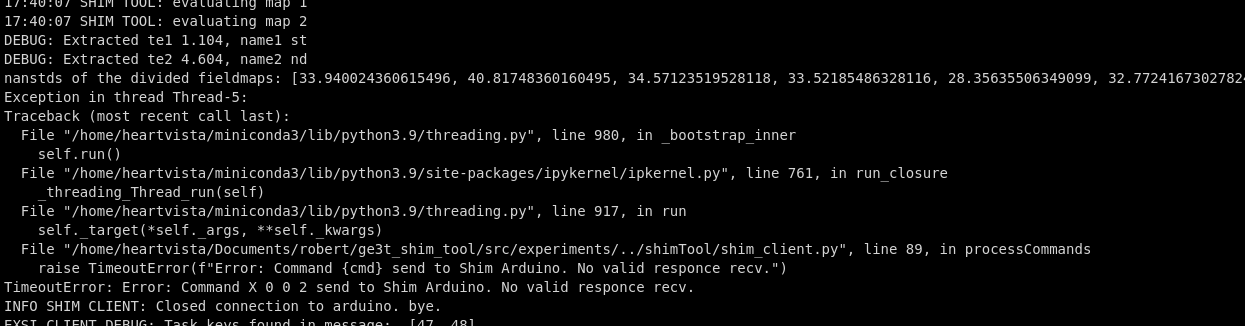
## Oh wow, look it did crash because one of the currents were not a float...

In [ ]:
tool.shimInstance.shimGetCurrent()

# time to do it again

In [ ]:
referenceCurrent = 1.0
currents = [-2.0]
references = []
fieldmapss = []
for loopIdx in range(8):
    reference, fieldmaps = acquireCoil(tool, loopIdx, referenceCurrent, currents, background)
    references.append(reference)
    fieldmapss.append(fieldmaps)
    plotDivAvgsOfReference(reference, referenceCurrent, fieldmaps, currents, loopIdx)

### ok, verified that this is working now... now to kick off the full experiment.